In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [4]:
img_size = 48

In [5]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [7]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [8]:
len(train_generator)

359

In [9]:
X_train.shape

(64, 48, 48, 1)

In [10]:
y_train.shape

(64, 7)

In [11]:
X_test.shape

(64, 48, 48, 1)

In [12]:
y_test.shape

(64, 7)

In [13]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


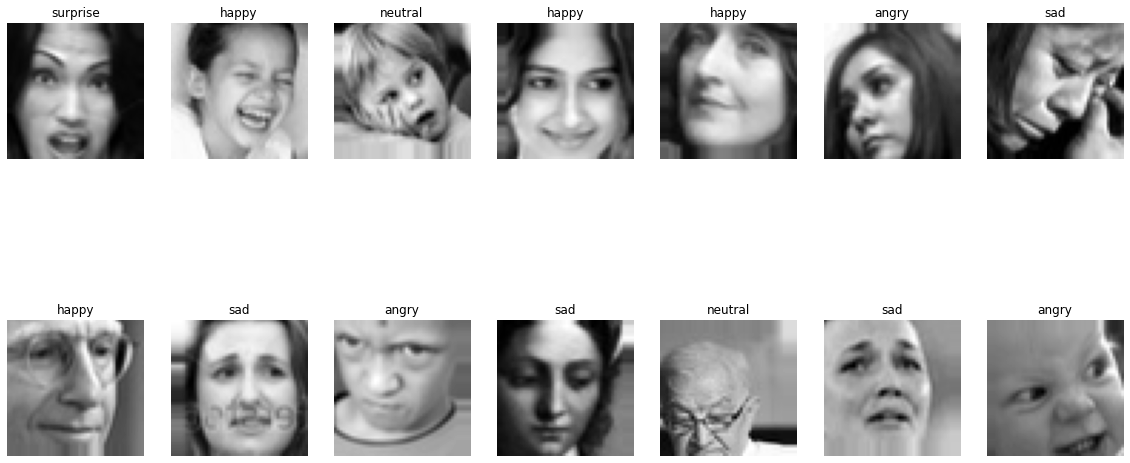

In [14]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [15]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [16]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [17]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [18]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [20]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [21]:
model = ResNet34(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 7, 7, 128)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11

 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 4, 4, 256)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 4, 4, 256)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_21[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_28 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 2, 2, 512)    131584      ['activation_26[0][0]']          
                                                                                                  
 add_13 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_28[0][0]', 
                                                                  'conv2d_31[0][0]']              
                                                                                                  
 activation_28 (Activation)     (None, 2, 2, 512)    0           ['add_13[0][0]']                 
          

In [22]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [23]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = 60,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/60
359/359 [==============================] - 68s 164ms/step - loss: 1.9953 - accuracy: 0.1886 - val_loss: 1.8348 - val_accuracy: 0.2898
Epoch 2/60
359/359 [==============================] - 59s 163ms/step - loss: 1.7930 - accuracy: 0.3036 - val_loss: 2.0314 - val_accuracy: 0.2786
Epoch 3/60
359/359 [==============================] - 60s 166ms/step - loss: 1.7197 - accuracy: 0.3261 - val_loss: 1.5978 - val_accuracy: 0.3785
Epoch 4/60
359/359 [==============================] - 60s 167ms/step - loss: 1.6210 - accuracy: 0.3717 - val_loss: 2.1471 - val_accuracy: 0.2423
Epoch 5/60
359/359 [==============================] - 60s 168ms/step - loss: 1.5656 - accuracy: 0.3964 - val_loss: 1.5726 - val_accuracy: 0.4022
Epoch 6/60
359/359 [==============================] - 66s 185ms/step - loss: 1.5035 - accuracy: 0.4106 - val_loss: 1.7504 - val_accuracy: 0.2870
Epoch 7/60
359/359 [==============================] - 103s 288ms/step - loss: 1.4787 - accuracy: 0.4218 - val_loss: 1.4714 - val_a

359/359 [==============================] - 62s 173ms/step - loss: 0.7309 - accuracy: 0.6959 - val_loss: 1.1743 - val_accuracy: 0.5663
Epoch 58/60
359/359 [==============================] - 62s 174ms/step - loss: 0.7512 - accuracy: 0.6909 - val_loss: 1.3632 - val_accuracy: 0.5056
Epoch 59/60
359/359 [==============================] - 67s 188ms/step - loss: 0.7529 - accuracy: 0.6872 - val_loss: 1.1144 - val_accuracy: 0.6020
Epoch 60/60
359/359 [==============================] - 62s 172ms/step - loss: 0.7575 - accuracy: 0.6897 - val_loss: 1.4437 - val_accuracy: 0.5056


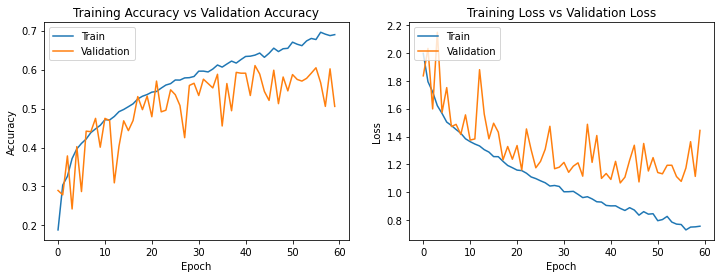

In [25]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [26]:
model.save('Resnet.h5')
model.save_weights('Resnet_weights.h5')

In [27]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 45ms/step - loss: 1.4437 - accuracy: 0.5056
final train accuracy = 53.97 , validation accuracy = 50.56


23/23 [==============================] - 2s 50ms/step
Confusion Matrix
[[27  3 43 59 21 22 16]
 [ 1  0  5  4  7  2  3]
 [27  9 53 47 27 28 13]
 [49 11 89 83 47 57 18]
 [31  6 61 53 34 38 23]
 [26  9 54 55 37 47 21]
 [24  4 34 43 23 27 11]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14       191
     disgust       0.00      0.00      0.00        22
        fear       0.16      0.26      0.20       204
       happy       0.24      0.23      0.24       354
     neutral       0.17      0.14      0.15       246
         sad       0.21      0.19      0.20       249
    surprise       0.10      0.07      0.08       166

    accuracy                           0.18      1432
   macro avg       0.15      0.15      0.14      1432
weighted avg       0.18      0.18      0.18      1432



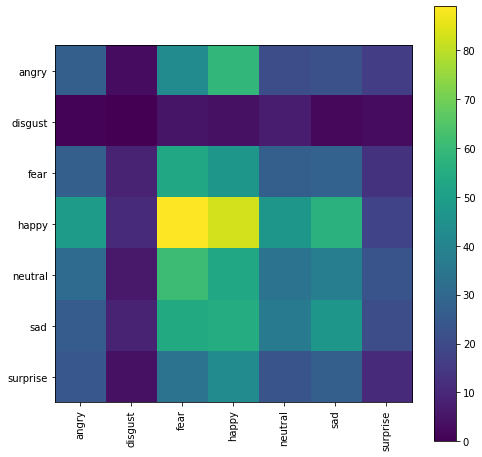

In [28]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 20s 54ms/step
Confusion Matrix
[[ 347   78  768  757  448  562  236]
 [  44    5   68   79   60   62   31]
 [ 417   78  747  786  467  559  224]
 [ 652  159 1375 1379  772  997  438]
 [ 466  116  941  938  557  644  310]
 [ 434  108  924  911  486  673  328]
 [ 283   78  612  621  355  401  187]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.11      0.12      3196
     disgust       0.01      0.01      0.01       349
        fear       0.14      0.23      0.17      3278
       happy       0.25      0.24      0.25      5772
     neutral       0.18      0.14      0.16      3972
         sad       0.17      0.17      0.17      3864
    surprise       0.11      0.07      0.09      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



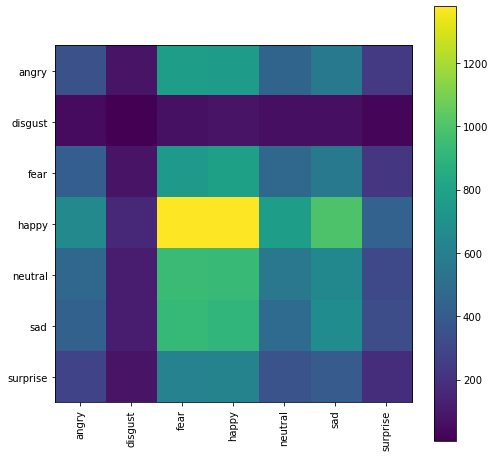

In [29]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)